🚌 Projet MDM - Mobilité Durable en Montagne ⛰️

*Author: Laurent Sorba*

*Date: 04/07/2025*

**Description :**

This notebook filters and extracts public transportation data (GTFS format) according to a department number. In our case specifically for the Isère department (code 38) in France.
The notebook downloads GTFS (General Transit Feed Specification) data from various transportation providers and uses precise administrative boundaries to spatially filter bus stops and routes that operate within the department boundaries.

See https://github.com/data-for-good-grenoble/mobilite_durable/issues/13

## Définition des fonctions

In [123]:
import json
from pathlib import Path

import geopandas as gpd
import gtfs_kit as gk
import pandas as pd
import requests


# 1. Télécharger et extraire les données GTFS
def download_gtfs_data(url):
    """Télécharge et extrait les données GTFS"""
    print(f"=== Télécharge les données GTFS depuis {url} ===")
    feed = gk.read_feed(url, dist_units="km")

    print(f"Chargé {len(feed.stops)} arrêts")
    print(f"Chargé {len(feed.routes)} lignes")
    print(f"Chargé {len(feed.stop_times)} horaires")
    print(f"Chargé {len(feed.trips)} trajets")

    return feed


# 2. Filtrer les arrêts par département de l'Isère par défaut
def filter_stops_by_department(feed, department_code="38"):
    """Filtre les arrêts par code département"""

    # 1. Charger les limites administratives du département
    department_boundary = get_department_boundary(department_code)

    if department_boundary is None:
        print(
            "Impossible de télécharger les limites administratives. Utilisation du filtrage par coordonnées."
        )
        exit()

    area_gdf = gpd.GeoDataFrame(
        {"department": [department_code]}, geometry=[department_boundary], crs="EPSG:4326"
    )

    # 2. Filtrer les arrêts qui se trouvent dans le département
    return gk.stops.get_stops_in_area(feed, area_gdf)


# 3. Filtrer les lignes de transport correspondant
def filter_routes_by_stops(routes_df, filtered_stops, trips_df=None, stop_times_df=None):
    """Filtre les lignes qui desservent les arrêts filtrés"""
    if trips_df is not None and stop_times_df is not None:
        # Trouver les trips qui passent par les arrêts filtrés
        department_stop_ids = filtered_stops["stop_id"].unique()
        trips_with_department_stops = stop_times_df[
            stop_times_df["stop_id"].isin(department_stop_ids)
        ]["trip_id"].unique()

        # Trouver les routes correspondantes
        routes_in_department = trips_df[trips_df["trip_id"].isin(trips_with_department_stops)][
            "route_id"
        ].unique()

        filtered_routes = routes_df[routes_df["route_id"].isin(routes_in_department)]
    else:
        # Si pas de données de correspondance, retourner toutes les routes
        filtered_routes = routes_df

    return filtered_routes


def get_department_boundary(department_code):
    """
    Charge ou télécharge depuis data.gouv.fr les limites administratives du département department_code
    """
    # URL des contours des départements français
    file = "../data/transportdatagouv/contour-des-departements.geojson"
    print(f"=== Charge les contours des départements français depuis le fichier {file} ===")

    try:
        # Test if file exists
        if not Path(file).is_file():
            print(f"-> Le fichier n'existe pas, téléchargement nécessaire.")
            download_from_data_gouv(file)
            # Vérifier que le téléchargement a réussi
            if not Path(file).is_file():
                print("Échec du téléchargement!")
                return None

        # Charger le GeoJSON
        france_departments = gpd.read_file(file)

        # Filtrer sur un département
        department_boundary = france_departments[france_departments["code"] == department_code]

        if not department_boundary.empty:
            return department_boundary.iloc[0].geometry
        else:
            print(f"Département {department_code} non trouvé dans les données")
            return None

    except Exception as e:
        print(f"Erreur lors du chargement des contours des départements: {e}")
        return None


def download_from_data_gouv(file_path):
    """
    Télécharge depuis data.gouv.fr - Contours des départements français
    """
    # URL des contours des départements français
    url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"
    print(f"=== Télécharge les contours des départements français {url} ===")
    try:
        # Télécharger le GeoJSON
        response = requests.get(url, timeout=30)
        response.raise_for_status()

        # Récupérer le contenu JSON
        geojson_data = response.json()

        # Créer le répertoire s'il n'existe pas
        file_path = Path(file_path)
        file_path.parent.mkdir(parents=True, exist_ok=True)

        # Sauvegarder dans le fichier
        with open(file_path, "w", encoding="utf-8") as f:
            json.dump(geojson_data, f, ensure_ascii=False, indent=2)

        print(f"Fichier sauvegardé avec succès : {file_path}")
        print(f"Nombre de départements : {len(geojson_data['features'])}")

    except Exception as e:
        print(f"Erreur lors du téléchargement depuis data.gouv.fr: {e}")
        return None

## Définition des variables

In [124]:
pd.set_option("display.max_columns", None)

# URLs des données GTFS contenant l'Isère
gtfs_sources = {
    # Definition https://transport.data.gouv.fr/datasets/agregat-oura
    "agregat-oura": "https://api.oura3.cityway.fr/dataflow/offre-tc/download?provider=OURA&dataFormat=GTFS&dataProfil=OPENDATA",
    # Definition https://transport.data.gouv.fr/datasets/reseau-cars-region-isere-38
    "reseau-cars-region-isere-38": "https://www.itinisere.fr/fr/donnees-open-data/169/OpenData/Download?fileName=CG38.GTFS.zip",
    # Definition https://transport.data.gouv.fr/datasets/horaires-theoriques-du-reseau-tag
    "TAG_Grenoble": "https://data.mobilites-m.fr/api/gtfs/SEM",
}

choose_department_code = "38"
data_set = "agregat-oura"
gtfs_url = gtfs_sources[data_set]

In [125]:
print(
    f"=== Filtrage avec limites administratives du '{choose_department_code}' sur '{data_set}' ==="
)

=== Filtrage avec limites administratives du '38' sur 'agregat-oura' ===


### Télécharger les données GTFS

In [126]:
result_feed = download_gtfs_data(gtfs_url)

=== Télécharge les données GTFS depuis https://api.oura3.cityway.fr/dataflow/offre-tc/download?provider=OURA&dataFormat=GTFS&dataProfil=OPENDATA ===
Chargé 24075 arrêts
Chargé 1456 lignes
Chargé 817371 horaires
Chargé 39595 trajets


### Filtrer les arrêts

In [127]:
result_filtered_stops = filter_stops_by_department(result_feed, choose_department_code)
print(
    f"Nombre d'arrêts dans le {choose_department_code}: {len(result_filtered_stops)} sur un total de {len(result_feed.stops)}"
)

=== Charge les contours des départements français depuis le fichier ../data/transportdatagouv/contour-des-departements.geojson ===
Nombre d'arrêts dans le 38: 7914 sur un total de 24075


### Filtrer les lignes

In [128]:
result_filtered_routes = filter_routes_by_stops(
    result_feed.routes, result_filtered_stops, result_feed.trips, result_feed.stop_times
)
print(
    f"Nombre de lignes dans le {choose_department_code}: {len(result_filtered_routes)} sur un total de {len(result_feed.routes)}"
)

Nombre de lignes dans le 38: 532 sur un total de 1456


### Filtrer les autres données (stop_times, trips)

In [129]:
stop_ids = set(result_filtered_stops["stop_id"])
route_ids = set(result_filtered_routes["route_id"])

result_filtered_stop_times = result_feed.stop_times[
    result_feed.stop_times["stop_id"].isin(stop_ids)
]
result_filtered_trips = result_feed.trips[result_feed.trips["route_id"].isin(route_ids)]

print(
    f"Nombre d'horaires dans le {choose_department_code}: {len(result_filtered_stop_times)} sur un total de {len(result_feed.stop_times)}"
)

print(
    f"Nombre de trajets dans le {choose_department_code}: {len(result_filtered_trips)} sur un total de {len(result_feed.trips)}"
)

Nombre d'horaires dans le 38: 116158 sur un total de 817371
Nombre de trajets dans le 38: 6752 sur un total de 39595


## Résultats

In [130]:
# Exemples d'arrêts
print("\nPremiers arrêts filtrés:")
print(
    result_filtered_stops[["stop_id", "stop_code", "stop_name", "stop_lat", "stop_lon"]].head(
        10
    )
)


Premiers arrêts filtrés:
                  stop_id stop_code               stop_name   stop_lat  \
0  FR:38001:ZE:3757:ISERE     16846            LA CHARRIERE  45.496367   
1  FR:38001:ZE:3758:ISERE     16847            LA CHARRIERE  45.496276   
2  FR:38001:ZE:3759:ISERE     16856             LES ETRAITS  45.502212   
3  FR:38001:ZE:3760:ISERE     16857             LES ETRAITS  45.502328   
4  FR:38001:ZE:3761:ISERE     16862              BEGENSIERE  45.500805   
5  FR:38001:ZE:3762:ISERE     16863              BEGENSIERE  45.501233   
6  FR:38001:ZE:4230:ISERE     17550                LA POSTE  45.537368   
7  FR:38001:ZE:4231:ISERE     17551                LA POSTE  45.537257   
8  FR:38001:ZE:4232:ISERE     17552  COLLEGE MARCEL BOUVIER  45.536197   
9  FR:38001:ZE:4233:ISERE     17553  COLLEGE MARCEL BOUVIER  45.536055   

   stop_lon  
0  5.609307  
1  5.609524  
2  5.593296  
3  5.593205  
4  5.606018  
5  5.606007  
6  5.584515  
7  5.584268  
8  5.591411  
9  5.591252  


In [131]:
# Exemples de lignes
print("\nPremières lignes filtrées:")
print(result_filtered_routes[["route_id", "route_short_name", "route_long_name"]].head(10))


Premières lignes filtrées:
                             route_id route_short_name  \
110          ARDECHE:Line:1000575:LOC              E04   
134          ARDECHE:Line:1000601:LOC              E95   
213       BOURGOINxJALLIEU:Line:1:LOC                1   
214  BOURGOINxJALLIEU:Line:1021x2:LOC             1021   
215  BOURGOINxJALLIEU:Line:1131x2:LOC             1131   
216  BOURGOINxJALLIEU:Line:1141x2:LOC             1141   
217  BOURGOINxJALLIEU:Line:1390x2:LOC             1390   
218       BOURGOINxJALLIEU:Line:2:LOC                2   
219  BOURGOINxJALLIEU:Line:2091x2:LOC             2091   
220       BOURGOINxJALLIEU:Line:3:LOC                3   

                     route_long_name  
110  Annonay - St Rambert - le Péage  
134  Annonay - St Rambert - Le Péage  
213                                1  
214                             1021  
215                             1131  
216                             1141  
217                             1390  
218                  

## Affichage des arrêts filtrés sur une carte

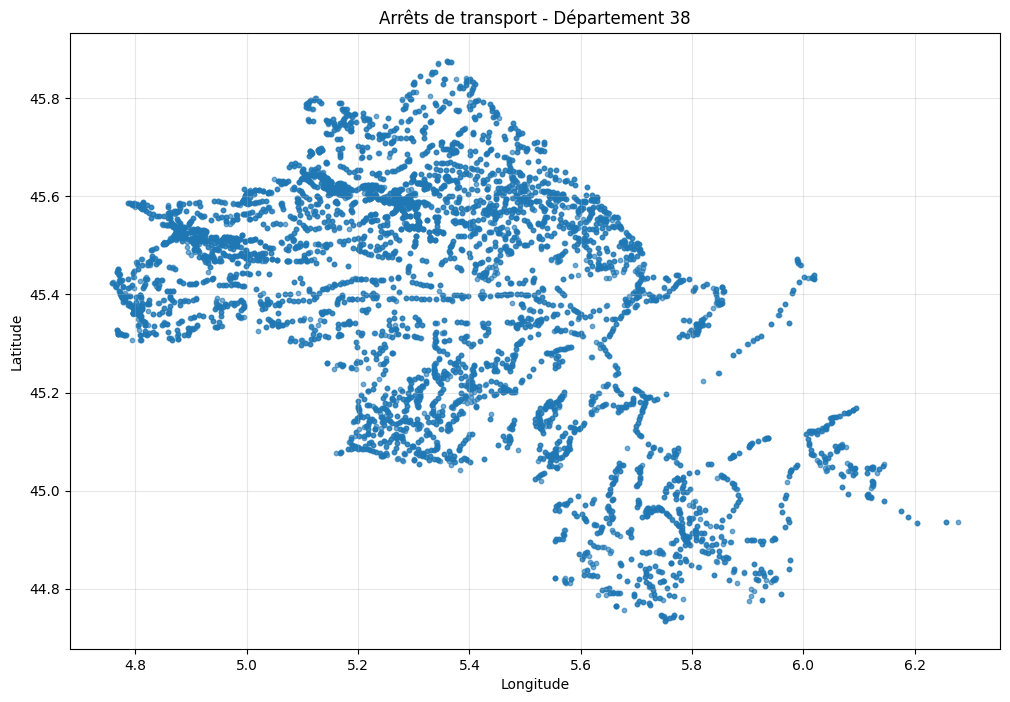

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(
    result_filtered_stops["stop_lon"], result_filtered_stops["stop_lat"], alpha=0.6, s=10
)
plt.title(f"Arrêts de transport - Département {choose_department_code}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.show()